### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import gpytorch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Visualization

In [3]:
def visimg(img1, img2, figsize=(10, 4)):
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    axs[0].imshow(img1, cmap="grey")
    axs[1].imshow(img2, cmap="grey")
    axs[0].axis("off")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

In [4]:
def visflo(u, v, c, sr, scale, agg=max, log=True, figsize=(10, 5), title=""):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_axes([0.05, 0.5, 0.4, 0.4])
    ax2 = fig.add_axes([0.55, 0.5, 0.4, 0.4])
    ax3 = fig.add_axes([0.00, 0.0, 0.3, 0.4])
    ax4 = fig.add_axes([0.35, 0.0, 0.3, 0.4])
    ax5 = fig.add_axes([0.70, 0.0, 0.3, 0.4])

    mag = np.sqrt(u ** 2 + v ** 2)
    im1 = ax3.imshow(mag, cmap="viridis")
    im2 = ax4.imshow(u,   cmap="coolwarm")
    im3 = ax5.imshow(v,   cmap="coolwarm")
    
    plt.colorbar(im1, ax=ax3, shrink=0.8)
    plt.colorbar(im2, ax=ax4, shrink=0.8)
    plt.colorbar(im3, ax=ax5, shrink=0.8)
    
    yy, xx = np.mgrid[0:u.shape[0]:sr[0], 0:u.shape[1]:sr[1]]
    uu, vv = u[::sr[0], ::sr[1]], v[::sr[0], ::sr[1]]
    ax1.quiver(xx, yy, uu, -vv, scale=scale)
    ax1.invert_yaxis()

    ax1.set(title="Vector Field", xticks=[], yticks=[])
    ax2.set(title="Covariance",   xticks=[], yticks=[])
    ax3.set(title="Magnitude",    xticks=[], yticks=[])
    ax4.set(title="U Component",  xticks=[], yticks=[])
    ax5.set(title="V Component",  xticks=[], yticks=[])

    viscov(c, (1, 1), agg, log, ax2)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [5]:
def viscov(cov, sr, agg=max, log=True, axs=None):
    if show := (axs is None):
        fig, axs = plt.subplots(figsize=(5, 4))
    
    yy, xx = np.mgrid[0:cov.shape[0]:sr[0], 0:cov.shape[1]:sr[1]]
    eig = np.zeros_like(xx, dtype=np.float32)
    cc = cov[::sr[0], ::sr[1]]
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            eig[i, j] = agg(np.linalg.eigvals(cc[i, j]))
    
    eig = np.log(eig) if log else eig
    cm = axs.pcolormesh(xx, yy, eig, cmap="Greys_r")
    plt.colorbar(cm, ax=axs)
    axs.invert_yaxis()
    
    if show:
        axs.axis("off")
        plt.show()

### Maximum Likelihood

In [6]:
def gaussian_mask(window=5, sigma=None, normalize=True):
    if not sigma:
        sigma = window / 3 
    center = (window - 1) / 2
    x = np.arange(window) - center
    y = np.arange(window) - center
    xx, yy = np.meshgrid(x, y)
    mask = np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma ** 2))
    return mask / mask.sum() if normalize else mask

In [7]:
def maximum_likelihood(img1, img2, window=9, sigma=1, rhos=[]):
    w = window // 2
    pad1 = cv.copyMakeBorder(img1.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    pad2 = cv.copyMakeBorder(img2.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    Ix = cv.Sobel(pad1, cv.CV_32F, 1, 0, ksize=3)
    Iy = cv.Sobel(pad2, cv.CV_32F, 0, 1, ksize=3)
    It = pad2 - pad1

    u = np.zeros(img1.shape, dtype=np.float32)
    v = np.zeros(img1.shape, dtype=np.float32)
    c = np.zeros(img1.shape + (2, 2), dtype=np.float32)
    mask = gaussian_mask(window, normalize=False)
    noise = ((sigma / mask) ** 2).flatten()
    noise = np.diag(noise) if len(rhos) else noise
    
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            m, n = i + w, j + w
            ix = Ix[m-w:m+w+1, n-w:n+w+1].flatten()
            iy = Iy[m-w:m+w+1, n-w:n+w+1].flatten()
            it = It[m-w:m+w+1, n-w:n+w+1].flatten()
            nabla = np.vstack([ix, iy])
            
            if len(rhos):
                cornoise = correlate(noise, rhos, (m, n), window)
                nabnoise = nabla @ np.linalg.inv(cornoise)
                ercov = np.linalg.inv(nabnoise @ nabla.T)
                flows = -ercov @ nabnoise @ it
            else:
                ercov = np.linalg.inv((nabla / noise) @ nabla.T)
                flows = -ercov @ (nabla / noise) @ it
            
            u[i, j] = flows[0]
            v[i, j] = flows[1]
            c[i, j] = ercov
    return u, v, c

### Multiresolution Algorithm

In [8]:
def gaussian_pyramid(img, levels):
    pyramid = [img.astype(np.float32)]
    for _ in range(levels - 1):
        pyramid.append(cv.pyrDown(pyramid[-1]))
    return pyramid[::-1]

In [9]:
def measurement_update(img1, img2, uu, vv, cc, window=9, sigma=1):
    w = window // 2
    pad1 = cv.copyMakeBorder(img1.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    pad2 = cv.copyMakeBorder(img2.astype(np.float32), w, w, w, w, cv.BORDER_REFLECT)
    Ix = cv.Sobel(pad1, cv.CV_32F, 1, 0, ksize=3)
    Iy = cv.Sobel(pad1, cv.CV_32F, 0, 1, ksize=3)
    It = pad2 - pad1
    
    u  = np.zeros(img1.shape, dtype=np.float32)
    v  = np.zeros(img1.shape, dtype=np.float32)
    c  = np.zeros(img1.shape + (2, 2), dtype=np.float32)
    mask = gaussian_mask(window, normalize=False)
    noise = ((sigma / mask) ** 2).flatten()

    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            m, n = i + w, j + w
            ix = Ix[m-w:m+w+1, n-w:n+w+1].flatten()
            iy = Iy[m-w:m+w+1, n-w:n+w+1].flatten()
            it = It[m-w:m+w+1, n-w:n+w+1].flatten()
            
            nabla = np.vstack([ix, iy])
            fpred = np.array([uu[i, j], vv[i, j]])
            innovation = it + nabla.T @ fpred
            
            ercov = np.linalg.inv(cc[i, j])
            ercov = np.linalg.inv((nabla / noise) @ nabla.T + ercov)
            fpost = fpred - ercov @ (nabla / noise) @ innovation
            
            u[i, j] = fpost[0]
            v[i, j] = fpost[1]
            c[i, j] = ercov
    return u, v, c

In [10]:
def multiresolution_flows(img1, img2, window, sigmaQ, sigmaR, k=3, r=2):
    lvls = int(np.log2(img1.shape).min() - k)
    pyr1 = gaussian_pyramid(img1, lvls)
    pyr2 = gaussian_pyramid(img2, lvls)
    u1, v1, c1 = maximum_likelihood(pyr1[0], pyr2[0], window[0], sigmaR[0])
    pyramid = [(u1, v1, c1)]
    A = r * np.eye(2)

    for i in range(1, len(pyr1)):
        h, w = pyr1[i].shape
        u2 = cv.pyrUp(u1, dstsize=(w, h)) * r
        v2 = cv.pyrUp(v1, dstsize=(w, h)) * r
        
        c2 = np.zeros((h, w) + (2, 2))
        for m in range(2):
            for n in range(2):
                c2[..., m, n] = cv.pyrUp(c1[..., m, n], dstsize=(w, h)) * (r ** 2)
        c2 += (sigmaQ[i] * np.eye(2))[None, None, ...]

        
        u1, v1, c1 = measurement_update(
            pyr1[i], pyr2[i], u2, v2, c2, window[i], sigmaR[i]
        )
        pyramid.append((u1, v1, c1))
    return pyramid

### Empirical Images

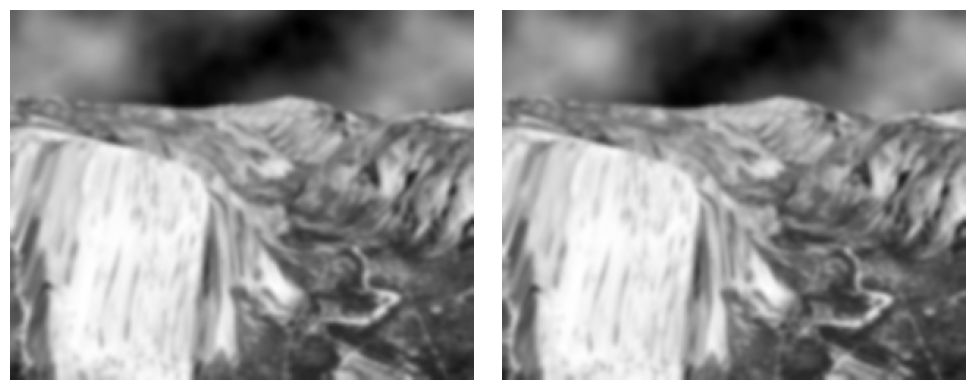

In [11]:
img1 = cv.imread("yosemite/YOS02.bmp")
img2 = cv.imread("yosemite/YOS03.bmp")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
img1 = cv.GaussianBlur(img1, (9, 9), -1)
img2 = cv.GaussianBlur(img2, (9, 9), -1)
visimg(img1, img2)

### Computation (Window 9)

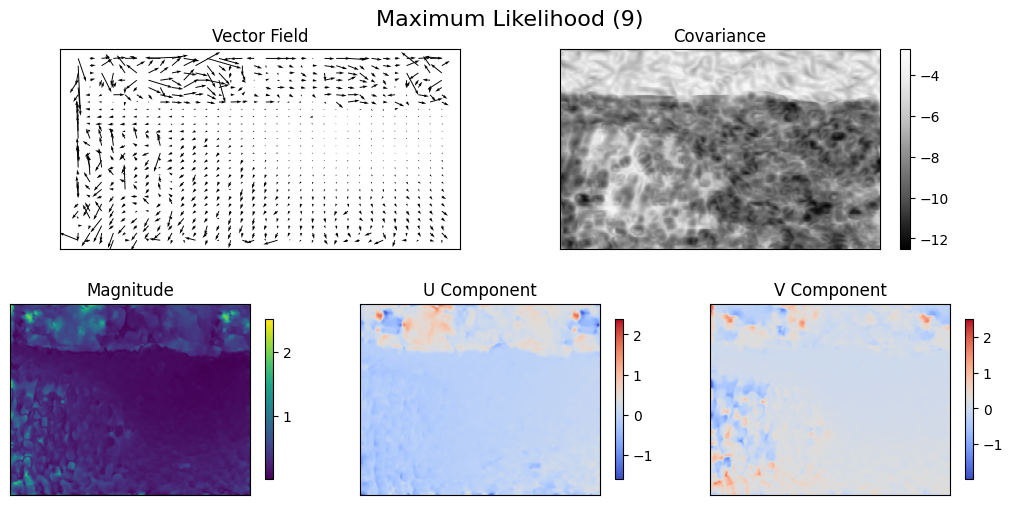

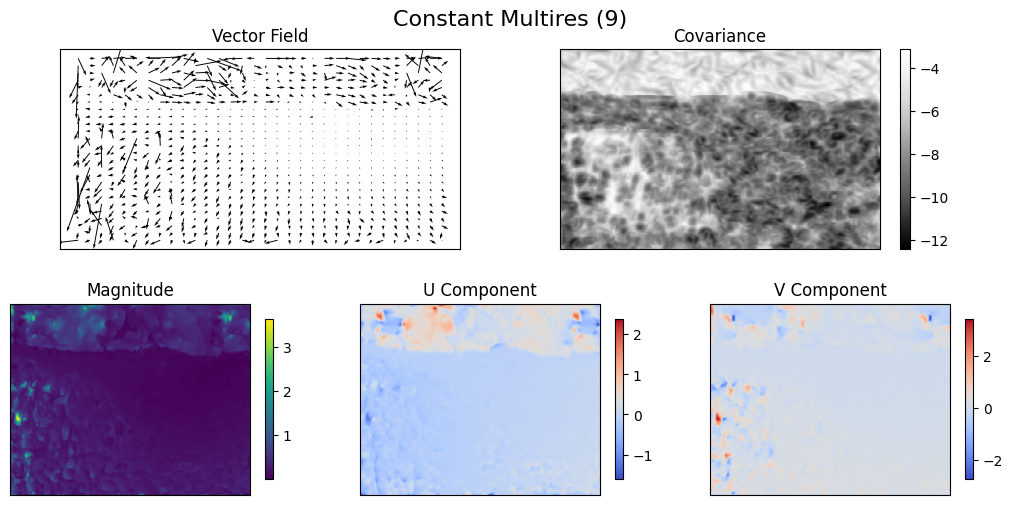

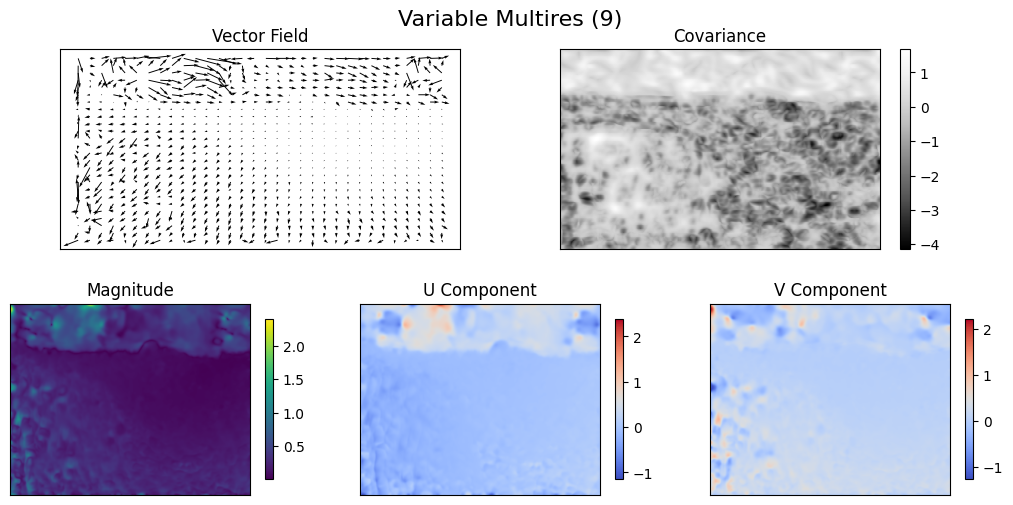

In [12]:
u, v, c = maximum_likelihood(img1, img2, 9, 1)
visflo(u, v, c, (10, 10), 20, title="Maximum Likelihood (9)")

pyrflows = multiresolution_flows(
    img1, img2,
    [ 9,  9,  9,  9],
    [ 1,  1,  1,  1],
    [ 1,  1,  1,  1]
)
u, v, c = pyrflows[-1]
visflo(u, v, c, (10, 10), 20, title="Constant Multires (9)")

pyrflows = multiresolution_flows(
    img1, img2,
    [ 9,  9,  9,  9],
    [64, 16,  4,  1],
    [ 1,  4, 16, 64]
)
u, v, c = pyrflows[-1]
visflo(u, v, c, (10, 10), 20, title="Variable Multires (9)")

### Computation (Window 15)

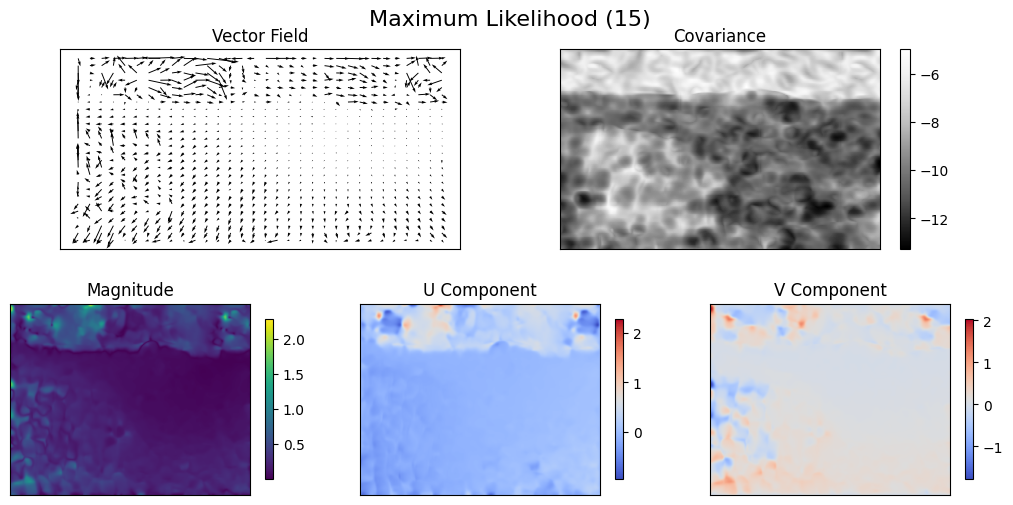

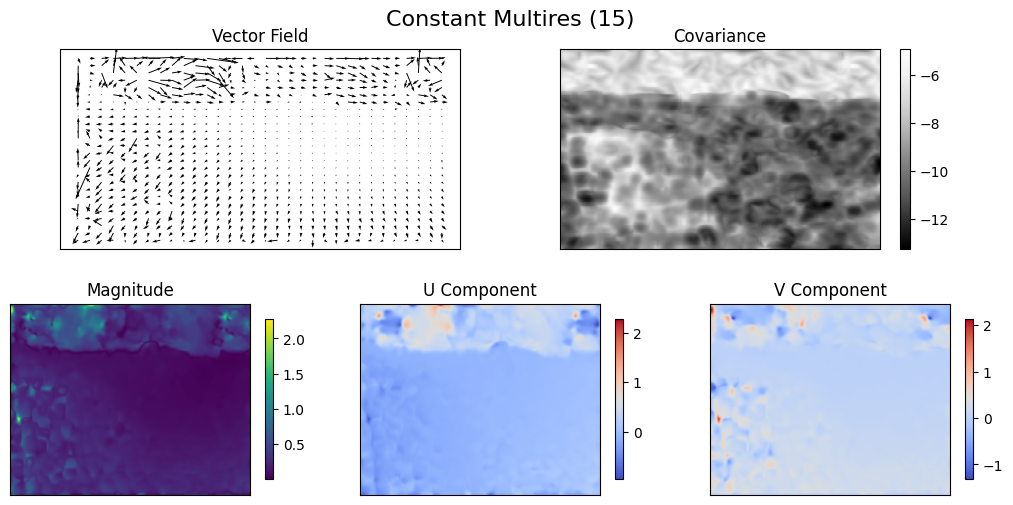

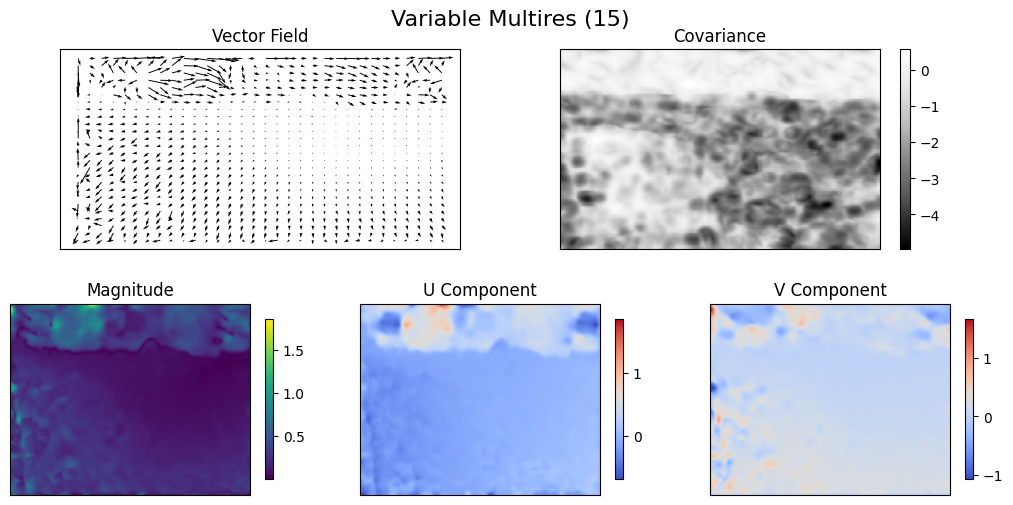

In [13]:
u, v, c = maximum_likelihood(img1, img2, 15, 1)
visflo(u, v, c, (10, 10), 20, title="Maximum Likelihood (15)")

pyrflows = multiresolution_flows(
    img1, img2,
    [ 9, 11, 13, 15],
    [ 1,  1,  1,  1],
    [ 1,  1,  1,  1]
)
u, v, c = pyrflows[-1]
visflo(u, v, c, (10, 10), 20, title="Constant Multires (15)")

pyrflows = multiresolution_flows(
    img1, img2,
    [ 9, 11, 13, 15],
    [64, 16,  4,  1],
    [ 1,  4, 16, 64]
)
u, v, c = pyrflows[-1]
visflo(u, v, c, (10, 10), 20, title="Variable Multires (15)")

### Computation (Window 25)

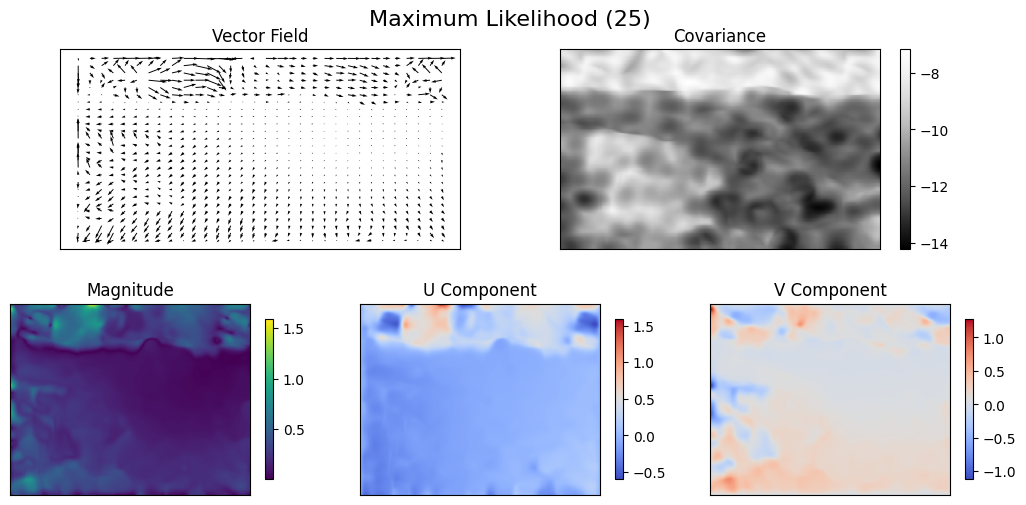

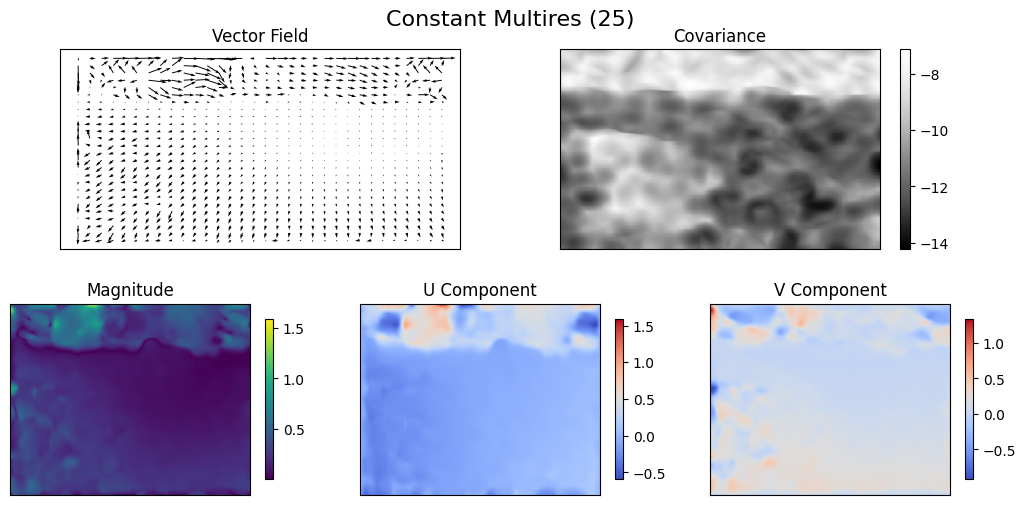

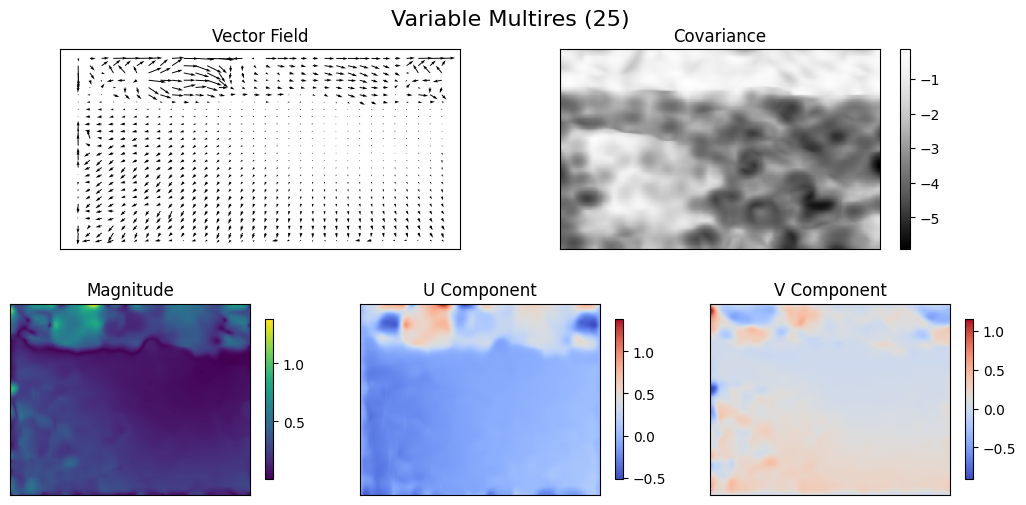

In [14]:
u, v, c = maximum_likelihood(img1, img2, 25, 1)
visflo(u, v, c, (10, 10), 20, title="Maximum Likelihood (25)")

pyrflows = multiresolution_flows(
    img1, img2,
    [ 9, 13, 19, 25],
    [ 1,  1,  1,  1],
    [ 1,  1,  1,  1]
)
u, v, c = pyrflows[-1]
visflo(u, v, c, (10, 10), 20, title="Constant Multires (25)")

pyrflows = multiresolution_flows(
    img1, img2,
    [ 9, 13, 19, 25],
    [64, 16,  4,  1],
    [ 1,  4, 16, 64]
)
u, v, c = pyrflows[-1]
visflo(u, v, c, (10, 10), 20, title="Variable Multires (25)")